# Step 1: Implement the vector gradient.

Implement the vector gradient as described in the lecture slides and the assignment description in the `color_sobel_edges()` function below.  Use sobel filters to estimate partial derivatives.  Use the `color_dot_product()` function (provided) to compute the necessary dot products to obtain gxx, gyy, and gxy.  Return an array containing the gradient magnitudes for each pixel, i.e. a graident magnitude image.  Optionally, return a second array containing the gradient directions for each pixel.

As usual, the input image must be dtype `float` or `uint8`.  If it is `uint8` convert it to `float` before processing.  Leave the magnitude image ouput as dtype `float` regardless of the input's dtype.



In [7]:
import skimage.util as util
import skimage.filters as filt
import numpy as np
import math as math

def color_dot_product(A, B):
    '''
    Element-by-element dot product in a 2D array of vectors.

    :return: An array in which index [i,j,:] is the dot product of A[i,j,:] and B[i,j,:].
    '''
    return np.sum(A.conj()*B, axis=2)



def color_sobel_edges(I):
    '''
    Finish me!
    
    :param I: Input image.
    :return: A 2-tuple which the 1st entry is a 2-d array containing the gradient magnitudes for each pixel,
    the 2nd entry contains the gradient directions for each pixel. 
    '''

    chan_R = I[:, :, 0]
    chan_G = I[:, :, 1]
    chan_B = I[:, :, 2]

    horizon_R = filt.sobel_h(chan_R)
    horizon_G = filt.sobel_h(chan_G)
    horizon_B = filt.sobel_h(chan_B)

    vertical_R = filt.sobel_v(chan_R)
    vertical_G = filt.sobel_v(chan_G)
    vertical_B = filt.sobel_v(chan_B)

    g_x = np.dstack((horizon_R, horizon_G, horizon_B))
    g_y = np.dstack((vertical_R, vertical_G, vertical_B))

    g_xx = color_dot_product(g_x, g_x)
    g_yy = color_dot_product(g_y, g_y)
    g_xy = color_dot_product(g_x, g_y)
    
    grad_direction_x2 = np.arctan2(2 * g_xy, g_xx-g_yy)

    grad_magnitude = np.sqrt(((g_xx+g_yy) + (g_xx-g_yy)*np.cos(grad_direction_x2) + 2*g_xy*np.sin(grad_direction_x2)) /2) 

    return (grad_magnitude, grad_direction_x2 /2)

# Step 2: Examine behavior of the kurtosis sharpness metric.

Write a function which:

* takes as input an input image, a minimum value of sigma, and a maximum value of sigma.
* applies different amounts of Gaussian blur to the original image for all integer values of sigma between the provided minimum and maximum values of sigma, inclusive. (reminder: sigma describes the standard deviation of the gaussian filter mask used to blur the image).
* For each blurred image, compute the gradient magnitude using `color_sobel_edges()`, then compute compute the kurtosis sharpness measure.  This is the log(kurtosis+3) where kurtosis is the kurtosis of the gradient magnitude image of the blurred image as described in the assignment description document.  See `scipy.stats.kurtosis()`.
* Returns a tuple consisting of the range object of sigma values used and the list of computed kurtosis values for each sigma.

Call the function using `mushroom.jpg` as the input image, a minimum sigma of 1, and a maximum sigma of 30.  Use a smaller max sigma until you are sure it's working, then increase to 30, as it can take a few minutes to do all the filtering.  Use the return values from your function to plot a line graph of gaussian blur sigma vs. blur measure (kurtosis) for the waterfall image.  Add appropriate axis labels and a descriptive title.  Sample output is provided in the assignment description document.



Text(0,0.5,'Sharpness (kurtosis)')

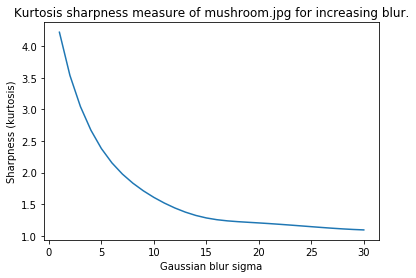

In [8]:
import skimage.io as io 
import scipy.stats as stats 
import matplotlib.pyplot as plt 

% matplotlib inline

def kurtosis_sharpness(I):
    I_grad_magnitude = color_sobel_edges(I)[0]
    k = stats.kurtosis(I_grad_magnitude.flatten())
    return math.log(k + 3)

def test_blur_measure(I, min_sigma, max_sigma):
    '''
    Finish me!
    
    :param I: Input image.
    :param min_sigma: The minimum standard deviation for Gaussian Kernel. 
    :param max_sigma: The maximum standard deviation for Gaussian Kernel.
    :return: A 2-d array which the 1st column consisting of the sigma values used and 
    the 2nd column consisting of computed kurtosis values for each sigma.
    '''
    i = math.ceil(min_sigma)
    j = math.floor(max_sigma) + 1
    result = np.zeros((j-i, 2))
    for s in range(i, j):
        I_blur = filt.gaussian(I, sigma = s, multichannel = True)
        result[s-i, :] = [s, kurtosis_sharpness(I_blur)]
    return result

img = util.img_as_float(io.imread('./mushroom.jpg'))
b = test_blur_measure(img, 1, 30)
plt.plot(b[:,0], b[:,1])
plt.xlabel('Gaussian blur sigma')
plt.ylabel('Sharpness (kurtosis)')
plt.title('Kurtosis sharpness measure of mushroom.jpg for increasing blur.')

# Step 3:  Create a local blur map

Write a function which:

* takes as input an input image and a square window size (in pixels). e.g. if `window_size = 11`, this means an 11 by 11 window.
* computes the local sharpness of the input image (i.e. log(kurtosis+3)) for each tiled, non-overlapping square window of the given window size
* stores each local sharpness in an array where each entry represents one window of the input image (the size of this array can be computed by integer division of the original image dimensions by the window size)
* returns the array of local sharpnesses.

Then call the function you just wrote with `mushroom.jpg` as the input image and 100 as the window size.  Plot the returned array as an image using `plt.imshow()`.  Do not rescale this image with `vmin=` or `vmax=`, and use the default colormap (don't change it to `'gray'`).  Add a color scale bar to the figure using `plt.colorbar()`.  Sample output is provided in the assignment description document.



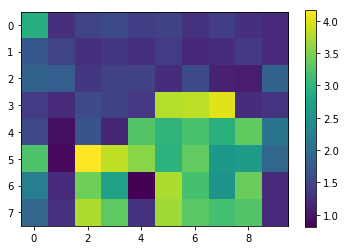

In [9]:
def sharpness_map(I, window_size):
    '''
    
    Finish me!
    
    :param I: Input image.
    :param window_size: Size of window (in pixels). 
    :return: A 2-d array of local sharpnesses.
    '''
    s_map = np.zeros((np.size(I, 0) // window_size, np.size(I, 1) // window_size)) 
    for r in range(0, np.size(s_map, 0)):
        for c in range(0, np.size(s_map, 1)):
            s_map[r, c] = kurtosis_sharpness(I[r*window_size:(r+1)*window_size-1, c*window_size:(c+1)*window_size-1])
    return s_map

s = sharpness_map(img, window_size=100)
plt.imshow(s)
plt.colorbar()

# Step 4: Try it on another image.

Use the functions you wrote to produce the same plots as in steps 2 and 3 but for the `waterfall.jpg` image instead.


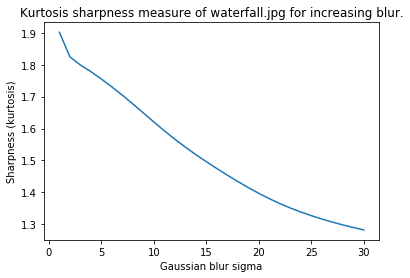

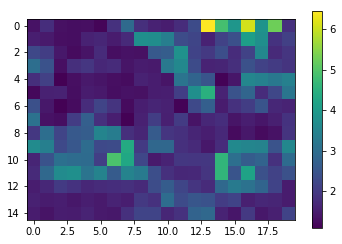

In [10]:
# Write your code here.
img = util.img_as_float(io.imread('./waterfall.jpg'))
b = test_blur_measure(img, 1, 30)
plt.figure()
plt.plot(b[:,0], b[:,1])
plt.xlabel('Gaussian blur sigma')
plt.ylabel('Sharpness (kurtosis)')
plt.title('Kurtosis sharpness measure of waterfall.jpg for increasing blur.')

s = sharpness_map(img, window_size=100)
plt.figure()
plt.imshow(s)
plt.colorbar()

# Step 5: Thinking and Qualitative Analysis

### Answer the following questions, right here in this block.

1. Do you think that the log(kurtosis+3) measurement of sharpness (hereafter called the "sharpness measure") is a good measure for characterizing global image blur (the general amount that the entire image is blurred)?  Explain and justify your answer.

	_Your answer:_  
    Yes it is a good measure for characterizing global image blur. As we increase the sigma of gaussian filter, we get more blurred images and the corresponding sharpness value decreases.

2. Is the sharpness measure effective at characterizing variations in local blur?  Does it respond to different regions of images appropriately?  Explain and justify your answers.

	_Your answer:_ 
    Yes it is effective at characterizing variations in local blur and it responds to different regions of images appropriately. For example the bottom right part of mushroom.jpg is less blurred than the rest part of the image, we can see that the sharpness measure for this region is significantly higher. While the windows of waterfall.jpg have similar blurriness so we see less extreme sharpness values.    

3. Think of what the shape of a histogram of gradient magnitudes would look like for a sharp image.  Why does this set of gradient magnitudes have high kurtosis?  (It might help to look up kurtosis and see what it measures about a histogram!)

	_Your answer:_ 
    For a sharp image the histogram of gradient magnitudes would have high degree of peakedness and looks heavy-tailed. This set of gradient magnitudes have high kurtosis when there are many small and also many large deviations from the mean gradient magnitude.

4. Now think what would happen as that same image gets blurrier.  Explain how the shape of the histogram would change, and the corresponding effect on the kurtosis.

	_Your answer:_ 
    The shape of the hitogram will have lower degree of peakedness, and be more light-tailed. The kurtosis will decrease. 